# Focus time stratification

In [8]:
# Stratify questions based on year
import pandas as pd

question_type = 'time'
# data, dataset_name = pd.read_csv('/home/wallat/temporal-llms/data/ArchivalQA/splits/ArchivalQATime/ArchivalQATime_train.csv'), "archivalQA_time_train"
# pred_data, model_name = pd.read_csv('/home/wallat/temporal-llms/data/predictions/alpaca-7b_ArchivalQA_time_train_set_gpt_style_predictions.csv', delimiter="\t"), "alpaca"
# pred_data, model_name = pd.read_csv('/home/wallat/temporal-llms/text-davinci-003_ArchivalQA_time_tuned_examples_predictions_2023_05_29T20:08.csv_ordered', delimiter="\t"), "davinci"


# upper_bound = 2008
# lower_bound = 1987
# intervals = [(year, year+1) for year in range(1987, 2008, 1)]

data, dataset_name = pd.read_csv('/home/wallat/temporal-llms/data/templama/preprocessed/templamaQA.csv'), "TempLAMA"
# pred_data, model_name = pd.read_csv('/home/wallat/temporal-llms/alpaca-7b_TempLAMA_all_gpt_style_predictions.csv', delimiter="\t"), "alpaca"
pred_data, model_name = pd.read_csv('/home/wallat/temporal-llms/data/predictions/davinci/text-davinci-003_TempLAMA_all_tuned_examples_predictions_2023_05_30T09:17.csv_ordered', delimiter="\t"), "davinci"

upper_bound = 2021
lower_bound = 2009
intervals = [(year, year+1) for year in range(2010, 2021, 1)]

questions = data["Question"].to_list()

data.head()

,Question,Answer
0,Tom Brady played for which team in 2010?,New England Patriots
1,Tom Brady played for which team in 2011?,New England Patriots
2,Tom Brady played for which team in 2012?,New England Patriots
3,Tom Brady played for which team in 2013?,New England Patriots
4,Tom Brady played for which team in 2014?,New England Patriots


In [9]:
import re

years = []

for index, row in data.iterrows():
    question = row["Question"]
    
    try:
        years.append(int(re.search(r"(\s\d{4})", question).group(1)))
    except:
        years.append(None)

data = data.assign(Year=years)
data.head()

,Question,Answer,Year
0,Tom Brady played for which team in 2010?,New England Patriots,2010
1,Tom Brady played for which team in 2011?,New England Patriots,2011
2,Tom Brady played for which team in 2012?,New England Patriots,2012
3,Tom Brady played for which team in 2013?,New England Patriots,2013
4,Tom Brady played for which team in 2014?,New England Patriots,2014


In [10]:
# pred_data = pd.read_csv('/home/wallat/temporal-llms/data/predictions/alpaca-7b_ArchivalQA_time_train_set_gpt_style_predictions.csv', delimiter="\t")
# pred_data.head()

years = []

for index, row in pred_data.iterrows():
    question = row["question"]
    
    try:
        years.append(int(re.search(r"(\s\d{4})", question).group(1)))
    except:
        years.append(None)

pred_data = pred_data.assign(Year=years)
pred_data.head()

,q_id,question,answer,Year
0,0,Tom Brady played for which team in 2010?,New England Patriots,2010
1,1,Tom Brady played for which team in 2011?,New England Patriots,2011
2,2,Tom Brady played for which team in 2012?,New England Patriots,2012
3,3,Tom Brady played for which team in 2013?,New England Patriots,2013
4,4,Tom Brady played for which team in 2014?,New England Patriots,2014


In [11]:
# Find year numbers with regex
import re

years = []

num_found = 0
for question in questions:
    try:
        years.append(int(re.search(r"(\s\d{4})", question).group(1)))
        num_found += 1
    except:
        # print(question)
        ...

print(f"Found {num_found} questions containing year numbers in the list of {len(questions)} questions")
print("Minimum: ", min(years))
print("Maximum: ", max(years))

Found 50310 questions containing year numbers in the list of 50310 questions
Minimum:  1952
Maximum:  2020


In [12]:
# num values over 

num = 0

for year in years:
    if year > upper_bound:
        num += 1

print(f"{num} years over upper bound {upper_bound}")


num = 0

for year in years:
    if year < lower_bound:
        num += 1

print(f"{num} years under lower bound {lower_bound}")


filtered_years = [year for year in years if year <= upper_bound]
# len(filtered_years)

filtered_years = [year for year in filtered_years if year >= lower_bound]
print("Total years in dataset after filtering: ", len(filtered_years))

import plotly.express as px

fig = px.histogram(filtered_years, nbins=15) #, nbins=7
fig.show()

0 years over upper bound 2021
1 years under lower bound 2009
Total years in dataset after filtering:  50309


In [13]:
from evaluate import load

def compute_contains_metric(references, predictions):
    # New metric "contains answer"
    num_contains = 0

    for pred, ref in zip(predictions, references):
        predicted_answer = pred["prediction_text"].lower()
        ref_answers = ref["answers"]["text"]
        ref_answers = [x.lower() for x in ref_answers]

        contained = False
        for ref_answer in ref_answers:
            if ref_answer in predicted_answer:
                contained = True

        if contained:
            num_contains += 1

    return (num_contains / len(references)) * 100

def convert_to_references(dataset):
    # Convert to reference format (evaluate library)
    # {'answers': {'answer_start': [97], 'text': ['1976']}, 'id': '0'}
    references = []

    for ele in dataset:
        answers = ele["answers"]
        ref = {
            "id": str(ele["id"]),
            "answers": {"answer_start": len(answers) * [0], "text": answers},
        }

        references.append(ref)

    return references


def convert_to_predictions(model_predictions):
    predictions = []

    for index in range(0, len(model_predictions)):
        row = model_predictions.iloc[index]

        predictions.append({"prediction_text": row["answer"], "id": str(index)})

    # predictions[14]
    return predictions

def split_answers_with_multiple_options(data, question_type):
    dataset = []

    for index in range(0, len(data)):
        row = data.iloc[index]

        answers = row["Answer"]
        if "__or__" in answers:
            answers = answers.split("__or__")
        else:
            answers = [answers]

        dataset.append(
            {
                "id": str(index),
                "question": row["Question"],
                "answers": answers,
                "type": question_type,
            }
        )

    return dataset

def compute_metrics(references, predictions):
    squad_metric = load("squad")
    results = squad_metric.compute(predictions=predictions, references=references)
    results["contains"] = compute_contains_metric(references, predictions)

    # p_bert, r_bert, f1_bert = compute_bertscore(references, predictions)
    # results["Precision_bert"] = p_bert
    # results["Recall_bert"] = r_bert
    # results["F1_bert"] = f1_bert

    return results

In [14]:
# intervals = [(1900, 1910), (1910, 1920), (1920, 1930), (1930, 1940), (1940, 1950), (1950, 1960), (1960, 1970), (1970, 1980), (1980, 1990), (1990, 2000), (2000, 2010)]
# intervals = [(1980, 1981), (1981, 1982), (1982, 1983), (1983, 1984), (1984, 1985), (1985, 1986), (1986, 1987), (1987, 1988), (1988, 1989), (1989, 1990), 
#              (1990, 1991), (1991, 1992), (1992, 1993), (1993, 1994), (1994, 1995), (1995, 1996), (1996, 1997), (1997, 1998), (1998, 1999), (1999, 2000),
#              (2000, 2001), (2001, 2002), (2002, 2003), (2003, 2004), (2004, 2005), (2005, 2006), (2006, 2007), (2007, 2008), (2008, 2009), (2009, 2010)
# ]
# intervals = [(year, year+1) for year in range(1980, 2010, 1)]
# intervals = [(year, year+2) for year in range(1980, 2010, 2)]

# print(intervals)




results_list = []


for interval in intervals:
    # for interval in intervals:
    lower, upper = interval

    # find all questions in the interval
    df_year_filtered = data[(data['Year'] >= lower) & (data['Year'] < upper)]
    df_year_filtered

    df_pred_year_filtered = pred_data[(pred_data['Year'] >= lower) & (pred_data['Year'] < upper)]
    df_pred_year_filtered

    assert len(df_year_filtered) == len(df_pred_year_filtered)
    # break

    df_year_filtered = split_answers_with_multiple_options(df_year_filtered, question_type)
    references = convert_to_references(df_year_filtered)
    predictions = convert_to_predictions(df_pred_year_filtered)

    if len(df_year_filtered) == 0:
        print(f"The performance in the for {len(df_year_filtered)} questions in {interval} is: undefined")
        continue

    results = compute_metrics(references, predictions)

        # for key in results.keys():
        #     wandb.log({f"{ds_name} {question_type} {key}": results[key]})
        # wandb.log(results)

    results_list.append({"interval": str(interval), "EM": results['exact_match'], "F1": results['f1'], "Contains": results['contains'], "#questions": len(df_year_filtered)})

    print(f"The performance in the for {len(df_year_filtered)} questions in {interval} is: {results}")

The performance in the for 4089 questions in (2010, 2011) is: {'exact_match': 15.774027879677183, 'f1': 30.808148146540113, 'contains': 17.24137931034483}
The performance in the for 4295 questions in (2011, 2012) is: {'exact_match': 15.972060535506403, 'f1': 31.3041634011395, 'contains': 17.532013969732247}
The performance in the for 4443 questions in (2012, 2013) is: {'exact_match': 16.22777402655863, 'f1': 31.279690785027057, 'contains': 17.713256808462752}
The performance in the for 4579 questions in (2013, 2014) is: {'exact_match': 16.706704520637693, 'f1': 32.00600732429785, 'contains': 18.453810875737062}
The performance in the for 4627 questions in (2014, 2015) is: {'exact_match': 17.311432893883726, 'f1': 32.21421769606176, 'contains': 19.018802679922196}
The performance in the for 4635 questions in (2015, 2016) is: {'exact_match': 17.238403451995683, 'f1': 31.97452493105614, 'contains': 18.640776699029125}
The performance in the for 4678 questions in (2016, 2017) is: {'exact_m

In [20]:
df = pd.DataFrame(results_list)
# df.head()

fig = px.bar(df, x='interval', y='Contains', color="#questions")
fig.show()

In [16]:
# for metric in ["EM", "F1", "Contains"]:
#     fig = px.bar(df, x='interval', y=metric, color="#questions")
#     fig.write_image(f"/home/wallat/temporal-llms/outputs/time_strat/{model_name}_{dataset_name}_intervals_{intervals[0][1]-intervals[0][0]}_years_{metric}.svg")

In [17]:
df.head()

,interval,EM,F1,Contains,#questions
0,"(2010, 2011)",15.774028,30.808148,17.241379,4089
1,"(2011, 2012)",15.972061,31.304163,17.532014,4295
2,"(2012, 2013)",16.227774,31.279691,17.713257,4443
3,"(2013, 2014)",16.706705,32.006007,18.453811,4579
4,"(2014, 2015)",17.311433,32.214218,19.018803,4627


,Unnamed: 0,interval,EM,F1,Contains,BEM,#questions,MA
0,0,"(1987, 1988)",3.126656,9.571792,12.188659,0.291468,1887,NaN
1,1,"(1988, 1989)",3.063540,9.815965,13.161876,0.305219,2644,3.095098
2,2,"(1989, 1990)",3.374132,9.849794,14.224281,0.296394,3023,3.218836
3,3,"(1990, 1991)",4.694670,11.050650,14.754677,0.303565,2833,4.034401
4,4,"(1991, 1992)",6.463565,14.573972,18.526142,0.337176,2429,5.579118


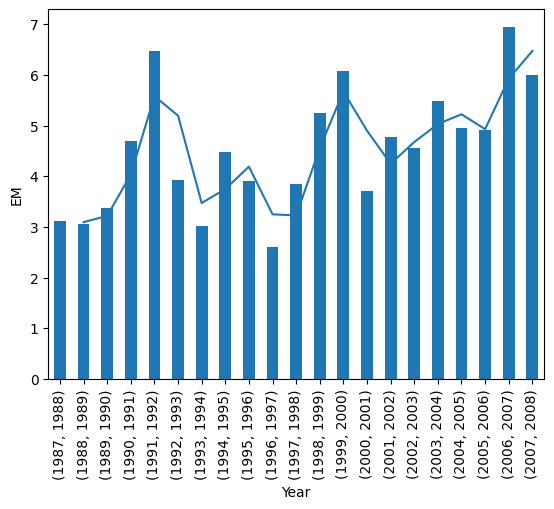

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import tikzplotlib

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


metric = "EM"

hist = df.plot(kind="bar", x='interval', y=metric, legend=False, ylabel=metric, xlabel="Year")

df['MA'] = df[metric].rolling(window=2).mean()

plt.plot(df['MA'])
df.head()
# plt.show()

# tikzplotlib_fix_ncols(hist)
# tikzplotlib.save(f"/home/wallat/temporal-llms/outputs/time_strat/{model_name}_{dataset_name}_intervals_{intervals[0][1]-intervals[0][0]}_years_{metric}.tex")

In [20]:
df['MA'].head()

0         NaN
1    3.095098
2    3.218836
3    4.034401
4    5.579118
Name: MA, dtype: float64

In [80]:
import pandas as pd
# import matplotlib.pyplot as plt
import seaborn as sns

# Archival QA
df_alp = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics/alpaca_archivalQA_time_train_metrics.csv', sep='\t')
df_dav = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics/davinci_archivalQA_time_train_metrics.csv', sep='\t')
df_fal = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics/falcon_archivalQA_time_train_metrics.csv', sep='\t')
df_ol = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics/openllama_archivalQA_time_train_metrics.csv', sep='\t')
df_rp3 = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/redpajama-3_archivalQA_time_train_metrics.csv', sep='\t')
df_rp7 = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/redpajama-7_archivalQA_time_train_metrics.csv', sep='\t')
dataset_name = "archivalQA"

# TempLAMA
# df_alp = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/alpaca_TempLAMA_metrics.csv', sep='\t')
# df_dav = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/davinci_TempLAMA_metrics.csv', sep='\t')
# df_fal = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/falcon_TempLAMA_metrics.csv', sep='\t')
# df_ol = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/openllama_TempLAMA_metrics.csv', sep='\t')
# df_rp3 = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/redpajama-3_TempLAMA_metrics.csv', sep='\t')
# df_rp7 = pd.read_csv('/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/redpajama-7_TempLAMA_metrics.csv', sep='\t')
# dataset_name = "TempLAMA"

model_info = {
    'Alpaca': (df_alp, 'absolute'),
    'Davinci': (df_dav, 'absolute_davinci'),
    'Falcon': (df_fal, 'absolute_falcon'),
    'OpenLLAMA': (df_ol, 'absolute_openllama'),
    'Redpajama_3': (df_rp3, 'absolute_redpjama-3'),
    'Redpajama_7': (df_rp7, 'absolute_redpjama-7'),
}


# traces = pd.DataFrame()


# traces['MA'] = df[metric].rolling(window=2).mean()
# traces['MA_f'] = df_fal[metric].rolling(window=2).mean()

# traces = pd.DataFrame({
#     "Alpaca": df_alp[metric].rolling(window=2).mean(),
#     "Dacvinci": df_dav[metric].rolling(window=2).mean(),
# })

# print(traces.head())
# sns.lineplot(traces, x=df["interval"], y=df[metric])
# plt.xticks(rotation=45, ha='right')

# hist = df.plot(kind="bar", x='interval', y=metric, legend=False, ylabel=metric, xlabel="Year")

In [66]:
# data = {
#     "Year": [1,2,1,2,1,2],
#     "Value": [1,2,2,1,3,3],
#     "Model": ["A", "A", "B", "B", "C", "C"]
# }

# df = pd.DataFrame(data)
# sns.lineplot(df, x='Year', y='Value', hue='Model')

# years = []
# values = []
# models = []

# years.append(df_alp['interval'])
# values.append(df_alp[metric].rolling(window=2).mean())
# models.append('Alpaca')

In [81]:
for metric in ["Contains", "F1", "EM"]:
    print("\n\n\n\n NEW METRIC: " + metric +"\n\n\n")

    plotting_data = "\n\n\n\n METRIC: " + metric +"\n\n\n"
    for model_name in model_info.keys():
        df, model_color = model_info[model_name]

        data = (df[metric].rolling(window=2).mean())
        plotting_data += ("\\addplot [semithick, " + model_color + "] % " + model_name + "\ntable {%")
        plotting_data += "\n" + data.to_string() + "\n};\n"

    with open(f"/home/wallat/temporal-llms/outputs/time_strat/metrics_no_bem/Output_{dataset_name}_{metric}.txt", "w") as text_file:
        text_file.write(plotting_data)





 NEW METRIC: Contains







 NEW METRIC: F1







 NEW METRIC: EM



